In [5]:
import re
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [6]:
def _smart_to_numeric(s: pd.Series, thresh = 0.9) -> pd.Series:
    parsed = pd.to_numeric(s, errors="coerce")
    return parsed if parsed.notna().mean() >= thresh else s

In [7]:
def load_and_clean(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [re.sub(r"\s+", " ", c.strip()) for c in df.columns]
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            df[c] = _smart_to_numeric(df[c], thresh=0.9)
    return df

In [8]:
def numeric_candidates(df: pd.DataFrame, exclude=()):
    ban = set(exclude or [])
    return [c for c in df.select_dtypes(include=[np.number]).columns if c not in ban]

In [9]:
def pearson_corr(df: pd.DataFrame, target: str, exogs: list, top_k: int | None = None) -> pd.DataFrame:
    """
    Correlación de Pearson (r) entre exógenas y target.
    Devuelve DataFrame ordenado por |r| con columnas: variable, r, abs_r.
    Si top_k no es None, retorna solo ese top.
    """
    rows = []
    for x in exogs:
        if x == target or x not in df.columns:
            continue
        sub = df[[x, target]].dropna()
        if sub.empty or sub[x].nunique() < 2 or sub[target].nunique() < 2:
            continue
        r = np.corrcoef(sub[x], sub[target])[0, 1]
        if np.isfinite(r):
            rows.append({"variable": x, "r": float(r), "abs_r": float(abs(r))})

    corr_df = (pd.DataFrame(rows)
               .sort_values("abs_r", ascending=False)
               .reset_index(drop=True))

    if top_k is not None:
        corr_df = corr_df.head(top_k)

    return corr_df[["variable", "r", "abs_r"]]

In [10]:
def pearson_table(df: pd.DataFrame, target: str, exogs: list) -> pd.DataFrame:
    """Tabla de correlación de Pearson r (exógenas originales vs target)."""
    rows = []
    for x in exogs:
        if x == target or x not in df.columns: 
            continue
        sub = df[[x, target]].dropna()
        if sub.empty or sub[x].nunique()<2 or sub[target].nunique()<2:
            continue
        r = np.corrcoef(sub[x], sub[target])[0,1]
        rows.append({"variable": x, "r": r, "abs_r": abs(r)})
    corr_df = pd.DataFrame(rows).sort_values("abs_r", ascending=False).reset_index(drop=True)
    return corr_df[["variable","r","abs_r"]]

In [11]:
def scatter_with_fit(df: pd.DataFrame, x: str, y: str, r: float):
    sub = df[[x, y]].dropna()
    if sub.empty: 
        return
    m, b = np.polyfit(sub[x], sub[y], 1)
    xs = np.linspace(sub[x].min(), sub[x].max(), 100)
    plt.figure(figsize=(6, 4.5))
    plt.scatter(sub[x], sub[y], alpha=0.5)
    plt.plot(xs, m*xs + b)
    plt.title(f"{y} vs {x}  (r = {r:.3f})")
    plt.xlabel(x); plt.ylabel(y)
    plt.tight_layout(); plt.show()

In [12]:
def play_regression(
    csv_path,
    target,
    exog=None,
    auto_k=None,
    drops=None,
    test_size=0.2,
    random_state=42,
    degree=2,
    interaction_only=False
):
    # 1) Datos
    df = load_and_clean(csv_path)
    assert target in df.columns, f"'{target}' no está en el CSV."
    drops = drops or []
    cand = numeric_candidates(df, exclude=[target] + drops)

    # 2) Selección de exógenas (originales) con la función unificada
    if exog:
        X_cols = [c for c in exog if c in df.columns and c != target]
        # También construiremos corr para el reporte:
        corr_all = pearson_corr(df, target, X_cols)
    else:
        # Calcula correlaciones una sola vez sobre candidatos
        corr_all = pearson_corr(df, target, cand)
        if auto_k:
            X_cols = corr_all.head(auto_k)["variable"].tolist()
        else:
            X_cols = corr_all["variable"].tolist()

    if not X_cols:
        raise ValueError("No hay exógenas válidas. Ajusta EXOG/AUTO_K/DROPS.")

    data = df[[target] + X_cols].dropna(subset=[target])
    X, y = data[X_cols], data[target]

    # 3) Polinómica: imputación → polinomio → LR
    model = Pipeline(steps=[
        ("imp", SimpleImputer(strategy="median")),
        ("poly", PolynomialFeatures(degree=degree, include_bias=False, interaction_only=interaction_only)),
        ("lr", LinearRegression())
    ])
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(Xtr, ytr)

    # 4) Métricas
    r2_tr = r2_score(ytr, model.predict(Xtr))
    r2_te = r2_score(yte, model.predict(Xte))

    # 5) CORRELACIONES (r) para las X usadas (filtramos de corr_all para no recalcular)
    corr_df = corr_all[corr_all["variable"].isin(X_cols)].reset_index(drop=True)

    print("\n" + "="*74)
    print(f"Objetivo: {target}")
    print(f"Modelo  : Regresión Polinómica (grado={degree}, interaction_only={interaction_only})")
    print(f"Exógenas base ({len(X_cols)}): {', '.join(X_cols[:12])}{' ...' if len(X_cols)>12 else ''}")
    print(f"R² (train): {r2_tr:.3f} | R² (test): {r2_te:.3f}")

    # 6) Tabla de correlaciones (r)
    print("\nCorrelación de Pearson (exógenas originales vs objetivo): r ∈ [-1, 1]")
    display(corr_df.style.format({"r": "{:.3f}", "abs_r": "{:.3f}"}))

    # 7) Coeficientes del modelo polinómico (NO son r)
    poly = model.named_steps["poly"]
    lr = model.named_steps["lr"]
    feat_names = poly.get_feature_names_out(X_cols)
    coefs = pd.Series(lr.coef_, index=feat_names).sort_values(key=np.abs, ascending=False)
    kshow = min(15, len(coefs))
    print("\nTop términos polinómicos por |coef| (NO son correlaciones):")
    display(coefs.head(kshow).to_frame("coef").style.format(precision=6))

    # 8) 2 gráficos con r (sobre variables originales)
    top2 = list(zip(corr_df["variable"], corr_df["r"]))[:min(2, len(corr_df))]
    for x, r in top2:
        scatter_with_fit(df, x, target, r)

    # 9) Conclusiones breves
    def _fmt_corr(r):
        s = "positiva" if r >= 0 else "negativa"
        mag = abs(r)
        lvl = "fuerte" if mag>=0.7 else "moderada" if mag>=0.4 else "débil" if mag>=0.2 else "muy débil"
        return f"{s} {lvl} (r={r:.3f})"
    concl = [f"• R²_test = {r2_te:.3f} con modelo polinómico de grado {degree}.",
             "• Las correlaciones (r) indican asociación lineal simple; "
             "los coeficientes polinómicos capturan efectos no lineales y de interacción y pueden ser >1 en magnitud."]
    if top2:
        concl.append("• Más asociadas (r): " + "; ".join([f"{target} vs {x}: {_fmt_corr(r)}" for x, r in top2]))
    print("\nCONCLUSIONES")
    print("\n".join(concl))

    return {
        "target": target,
        "r2_train": r2_tr,
        "r2_test": r2_te,
        "exog_base": X_cols,
        "corr_table": corr_df,
        "top_poly_coefs": coefs.head(kshow)
    }



Objetivo: Life expectancy
Modelo  : Regresión Polinómica (grado=2, interaction_only=False)
Exógenas base (8): Schooling, Income composition of resources, Adult Mortality, BMI, HIV/AIDS, Diphtheria, thinness 1-19 years, thinness 5-9 years
R² (train): 0.897 | R² (test): 0.895

Correlación de Pearson (exógenas originales vs objetivo): r ∈ [-1, 1]


,variable,r,abs_r
0,Schooling,0.752,0.752
1,Income composition of resources,0.725,0.725
2,Adult Mortality,-0.696,0.696
3,BMI,0.568,0.568
4,HIV/AIDS,-0.557,0.557
5,Diphtheria,0.479,0.479
6,thinness 1-19 years,-0.477,0.477
7,thinness 5-9 years,-0.472,0.472



Top términos polinómicos por |coef| (NO son correlaciones):


,coef
Income composition of resources^2,35.019390
Income composition of resources,5.562228
Schooling Income composition of resources,-2.212874
HIV/AIDS,-1.311518
Income composition of resources HIV/AIDS,-0.509043
thinness 5-9 years,-0.405361
BMI,0.310425
Schooling,0.245782
Schooling^2,0.081177
Income composition of resources thinness 1-19 years,0.072814


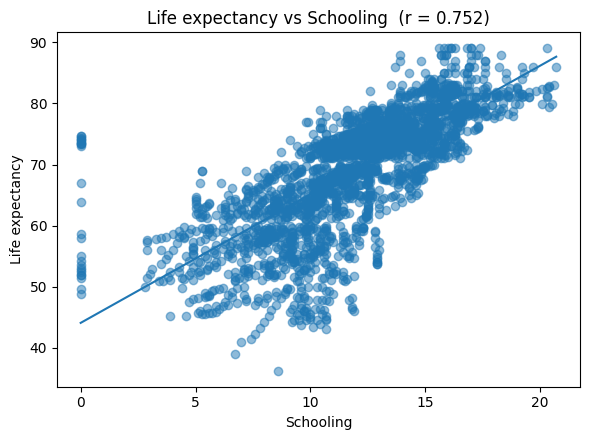

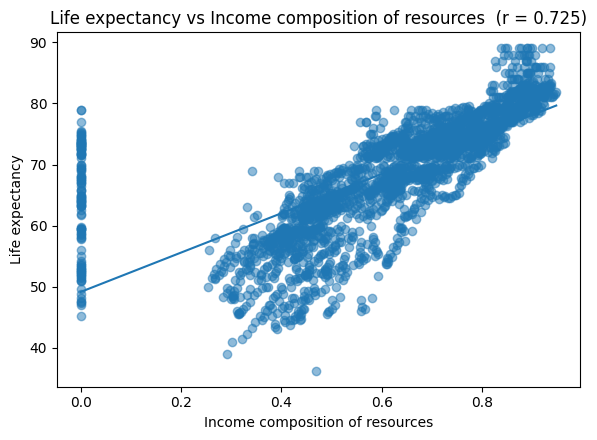


CONCLUSIONES
• R²_test = 0.895 con modelo polinómico de grado 2.
• Las correlaciones (r) indican asociación lineal simple; los coeficientes polinómicos capturan efectos no lineales y de interacción y pueden ser >1 en magnitud.
• Más asociadas (r): Life expectancy vs Schooling: positiva fuerte (r=0.752); Life expectancy vs Income composition of resources: positiva fuerte (r=0.725)


In [13]:
res = play_regression(
    csv_path=r"C:\Users\xavir\OneDrive\Escritorio\Life Expectancy Data (1).csv",
    target="Life expectancy",
    exog=None,
    auto_k=8,
    drops=None,
    degree=2,
    interaction_only=False
)